## ML Model for Dynamic Characters

### Imports

In [24]:
import keras
import numpy as np

In [25]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Read Data

In [26]:
def parse_header_file(path):
    with open(path, "r") as text_file:
        raw = text_file.read()
        data = raw.split('\n') # ignore empty list
        data = [ list(map(float, x.split(' '))) for x in data ]
        bones, vertices = data[0]
    return bones, vertices

In [56]:
from numpy import genfromtxt

# define constants
name = "research"
header = "../resources/occlusion/" + name + "_base.txt"
csvfile = "../resources/occlusion/" + name + "_data.csv"

# load data
bones, vertices = parse_header_file(header)
feature_len = 2 + int(3 * bones) # uv, 3 for each euler angle
data = genfromtxt(csvfile, delimiter=',')
# data = tf.concat([data[:,:-2], np.expand_dims(data[:,-1] - data[:,-2], axis=-1)], axis=-1) # compute delta ao

print("Dataset", data.shape)

Dataset (3258086, 10)


In [57]:
# split
sample_split = int(0.9 * data.shape[0])
np.random.shuffle(data)
# TODO: standardize

X_train = data[:sample_split, :feature_len]
y_train = data[:sample_split, feature_len:]
# y_train = y_train[:,1] - y_train[:,0]
y_train = y_train[:,1] # ignore base
print("Train:", X_train.shape, y_train.shape)

# test
np.random.shuffle(data)
X_test = data[sample_split:, :feature_len]
y_test = data[sample_split:, feature_len:]
y_test = y_test[:,1]
print("Test:", X_test.shape, y_test.shape)

Train: (2932277, 8) (2932277,)
Test: (325809, 8) (325809,)


In [58]:
# ignore first joing -> 3 angles
with tf.device("cpu:0"):
    Xp_train =tf.concat([X_train[:,:2], X_train[:,5:] / (np.pi/2)], axis=-1)
    Xp_test =tf.concat([X_test[:,:2], X_test[:,5:] / (np.pi/2)], axis=-1)
feature_len -= 3
print("Train:", Xp_train.shape, y_train.shape)
print("Test:", Xp_test.shape, y_test.shape)

Train: (2932277, 5) (2932277,)
Test: (325809, 5) (325809,)


In [59]:
print(Xp_train[0])
print(y_train[0])

tf.Tensor([0.755701   0.693365   0.95552744 0.         0.11110798], shape=(5,), dtype=float64)
0.041577


In [ ]:
# # read data
# name = "warrior"
# train_path = "../resources/occlusion/_" + name + "_train_data.txt"
# test_path = "../resources/occlusion/_" + name + "_test_data.txt"

# data = []
# bones = 0
# vertices = 0
# with open(train_path, "r") as text_file:
#     raw = text_file.read()
#     data = raw.split('\n')[:-1] # ignore empty list
#     data = [ list(map(float, x.split(' '))) for x in data ]
#     bones, vertices = data[0]
# train_data = np.array(data[1:])

# with open(test_path, "r") as text_file:
#     raw = text_file.read()
#     data = raw.split('\n')[:-1]
#     data = [ list(map(float, x.split(' '))) for x in data ]
#     bones, vertices = data[0]
# test_data = np.array(data[1:])

# # split data
# feature_len = int(3 * bones) # 3 for each euler angle

# np.random.shuffle(train_data)
# assert(len(train_data[0]) == feature_len + vertices)
# X_train = train_data[:, :feature_len]
# X_train = X_train / np.pi  #/ (2 * np.pi) # standardize
# y_train = train_data[:, feature_len:]

# assert(len(test_data[0]) == feature_len + vertices)
# np.random.shuffle(test_data)
# X_test = test_data[:, :feature_len]
# X_test = X_test / np.pi #/ (2 * np.pi) # standardize
# y_test = test_data[:, feature_len:]

### Data Visualization

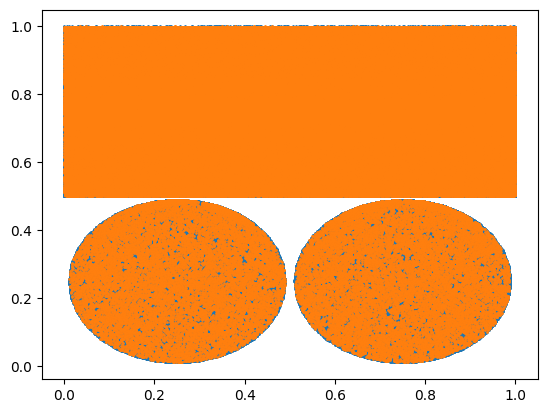

In [29]:
import matplotlib.pyplot as plt

plt.scatter(X_train[:,0], X_train[:,1], s=1)
plt.scatter(X_test[:,0], X_test[:,1], s=1)
plt.show()

### Encoding

### Build Model

<b>Inputs:</b> u, v, thetas
<br/><b>Output</b>: occlusion factor

In [30]:
# positional encoding
def positional_encoding(pos, output_dim):
    result = []
    for i in range(output_dim//2):
        result.append(tf.sin(2**i * pos))
        result.append(tf.cos(2**i * pos))
    return tf.concat(result, axis=-1)

In [114]:
# enc_dim = 6
# enc_train = positional_encoding(X_train[:,:2], enc_dim) # u,v * 6
# enc_test = positional_encoding(X_test[:,:2], enc_dim)
# with tf.device("cpu:0"):
#     Xp_train = tf.concat([enc_train, X_train], axis=-1)
#     Xp_test = tf.concat([enc_test, X_test], axis=-1)
# feature_len = Xp_test.shape[1]
# # print("Raw", X_train.shape, X_test.shape)
# print("Encoded", Xp_train.shape, Xp_test.shape)

Encoded (1440796, 209) (160089, 209)


In [115]:
# import keras.layers

# # hidden layers
# num_layers = 8
# embed_dim = 10

# # functional api model
# input_func = keras.Input(shape=(2,), name="DAO")
# embedding = positional_encoding(input_func, embed_dim//2)
# hidden_layers = keras.Sequential([keras.layers.Dense(256, activation='relu') for _ in range(num_layers)])
# x = hidden_layers(input_func)
# output_func = keras.layers.Dense(1, activation='relu')(x)

# # create model
# model = keras.Model(input_func, output_func)
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss=keras.losses.MeanSquaredError())

<b>Inputs:</b> thetas
<br/><b>Output</b>: occlusion factor for all vertices

In [120]:
# hidden_dim = 512
# inputs = keras.Input(shape=(feature_len,))
# x = keras.layers.Dense(hidden_dim, activation='relu')(inputs) # hidden
# x = keras.layers.Dense(hidden_dim, activation='relu')(x) # hidden
# x = keras.layers.Dense(hidden_dim, activation='relu')(x) # hidden
# x = keras.layers.Dense(hidden_dim, activation='relu')(x) # hidden
# x = keras.layers.BatchNormalization()(x)

# residual = keras.layers.Concatenate()([inputs, x])
# x = keras.layers.Dense(hidden_dim + feature_len, activation='relu')(residual) # hidden
# x = keras.layers.Dense(hidden_dim, activation='relu')(x) # hidden
# x = keras.layers.Dense(hidden_dim, activation='relu')(x) # hidden
# x = keras.layers.Dense(hidden_dim, activation='relu')(x) # hidden
# x = keras.layers.BatchNormalization()(x)

# output = keras.layers.Dense(1, activation='relu')(x) # output

# model = keras.Model(inputs=inputs, outputs=output, name="dao")

# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=10000,
#     decay_rate=0.95,
#     staircase=True)

# model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss=keras.losses.MeanSquaredError())

In [63]:
model = keras.Sequential([
    keras.Input(shape=(feature_len,)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation='relu')
])
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError())

In [54]:
# # build model
# model = keras.Sequential([
#     keras.layers.Dense(512, input_shape=(2,), activation='relu'), # hidden
#     keras.layers.Dense(512, activation='relu'), # hidden
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(512, activation='relu'), # hidden
#     keras.layers.Dense(512, activation='relu'), # hidden
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(512, activation='relu'), # hidden
#     keras.layers.Dense(512, activation='relu'), # hidden
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(512, activation='relu'), # hidden
#     keras.layers.Dense(512, activation='relu'), # hidden
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(1, activation='sigmoid') # output
# ])

# # Decay
# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=10000,
#     decay_rate=0.95,
#     staircase=True)
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss=keras.losses.MeanSquaredError())

What worked: 4 layers 256 nodes, relu. 3 * joints -> vertices ao

### Set up Tensorboard

In [39]:
%load_ext tensorboard
import datetime

### Train Model

In [69]:
# train model
log_dir = "logs_research/model_5layer_relu/"
checkpoint_dir = "networks/research_model.keras"

tensorboard_callback = tf.keras.callbacks.TensorBoard(
  log_dir=log_dir,
  histogram_freq=1
)
checkpoint_callback = keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_dir,
  monitor='val_loss',
  mode='min',
  save_best_only=True
)

model.fit(x=Xp_train, 
          y=y_train, 
          epochs=50,
          batch_size=128,
          validation_data=(Xp_test, y_test), 
          callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/50
22909/22909 [==============================] - 218s 9ms/step - loss: 5.3107e-04 - val_loss: 6.0631e-04
Epoch 2/50
22909/22909 [==============================] - 194s 8ms/step - loss: 5.2841e-04 - val_loss: 4.8900e-04
Epoch 3/50
22909/22909 [==============================] - 174s 8ms/step - loss: 5.2957e-04 - val_loss: 5.3551e-04
Epoch 4/50
22909/22909 [==============================] - 170s 7ms/step - loss: 5.2949e-04 - val_loss: 6.2159e-04
Epoch 5/50
22909/22909 [==============================] - 169s 7ms/step - loss: 5.2663e-04 - val_loss: 4.4104e-04
Epoch 6/50
22909/22909 [==============================] - 168s 7ms/step - loss: 5.3775e-04 - val_loss: 4.2931e-04
Epoch 7/50
22909/22909 [==============================] - 167s 7ms/step - loss: 5.2823e-04 - val_loss: 5.9897e-04
Epoch 8/50
22909/22909 [==============================] - 166s 7ms/step - loss: 5.3284e-04 - val_loss: 5.0970e-04
Epoch 9/50
22909/22909 [==============================] - 166s 7ms/step - loss: 5.2607e-

To beat: 5.3e-4 150 epochs

### Output Texture

In [70]:
loaded_model = keras.models.load_model("networks/research_model.keras")

resolution = 1024
input = []
uv = []
for i in range(resolution):
    for j in range(resolution):
        uv.append([i/resolution, j/resolution])
uv = np.array(uv)
# uv_enc = positional_encoding(uv, 6)
theta = np.zeros(shape=(resolution*resolution, 3)) # bones * 3
with tf.device("cpu:0"):
    input = tf.concat([uv, theta], axis=-1)
print(input.shape)

(1048576, 5)


In [71]:
out = loaded_model.predict(input)

32768/32768 [==============================] - 89s 3ms/step


(1024, 1024, 1)


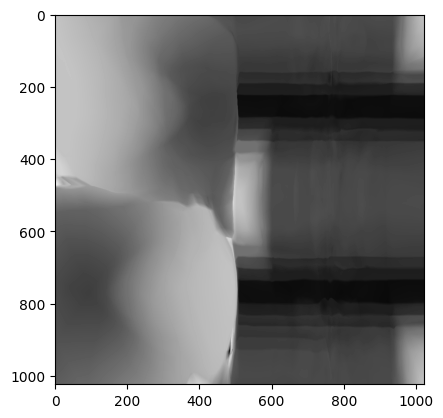

In [72]:
# arr = np.ndarray((1,80,80,1))#This is your tensor
# arr_ = np.squeeze(arr) # you can give axis attribute if you wanna squeeze in specific dimension
import matplotlib.pyplot as plt
img = np.reshape(1.0-out, (resolution,resolution,1))
print(img.shape)
plt.imshow(img, cmap='gray')
plt.savefig('renders/research_uv_fitting_2.png', bbox_inches='tight') # 4 min generation

UV fitting: ~6e-3 after 100-140 epochs (maria_base.keras)<br/>
UV fitting w/ tpose: ~1e-4 after 150 epochs (maria_delta_base.keras)<br/>
Things to test:
* Batch norm
* Learning rate adjustment
* Layer width/depth
* Play with embedding dim

In [23]:
%tensorboard --logdir logs/maria_base

UsageError: Line magic function `%tensorboard` not found.


### UV Data

### Test Accuracy

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=16)
print("test loss, test acc:", results)

2/2 [==============================] - 0s 6ms/step - loss: 0.0280 - mse: 0.0280
test loss, test acc: [0.028007308021187782, 0.028007308021187782]


### Get Model

In [ ]:
wab = model.get_weights()

In [ ]:
# manual evaluation 2 hidden layers: input = [u, v, theta]
# def manual_eval(input):
#     w1 = wab[0]
#     b1 = wab[1]
#     w2 = wab[2]
#     b2 = wab[3]
#     w3 = wab[4]
#     b3 = wab[5]

#     z1 = keras.activations.tanh(np.matmul(np.array(input), w1) + b1)
#     z2 = keras.activations.tanh(np.matmul(z1, w2) + b2)
#     z3 = keras.activations.tanh(np.matmul(z2, w3) + b3)
#     return z3.numpy()[0]

### Save to output file

In [ ]:
# save weights and biases as buffer
output_buf = str(len(model.layers)) + "\n" # layer count

for i in range(0, len(wab)-1, 2): # iterate through layers
    weights = wab[i]
    output_buf += str(weights.shape[0]) + " " + str(weights.shape[1]) + "\n" # input size output size
    for neuron in weights: # iterate through
        for edges in neuron:
            output_buf += str(edges) + " "
    for biases in wab[i+1]:
        output_buf += str(biases) + " "
    output_buf = output_buf[:-1] + "\n" # ignore extraneous space and end line
    

In [ ]:
with open("../resources/evaluators/model.txt", "w") as text_file:
    text_file.write(output_buf) # add more digits